In [21]:
import numpy as np
import h5py
import cv2
import matplotlib.pyplot as plt

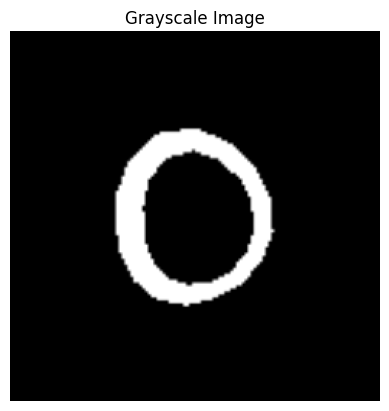

In [22]:
file_path ="data\\anatomicalSegmentations"
img = cv2.imread(file_path+'\\001.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')  # Optional: hides axes
plt.show()

2


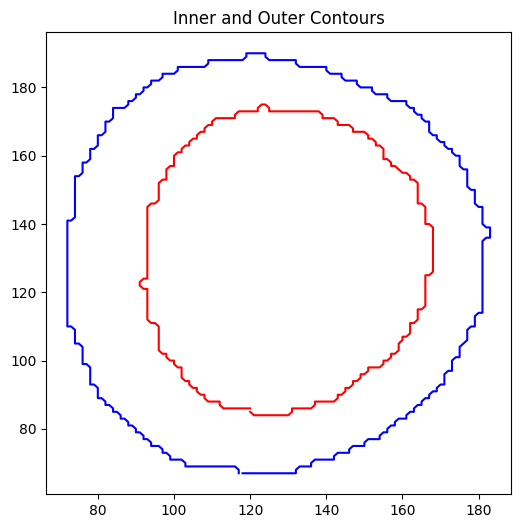

In [23]:
contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
print(len(contours))
outer = contours[0][:, 0, :]
inner = contours[1][:, 0, :]

plt.figure(figsize=(6, 6))
plt.plot(outer[:, 0], outer[:, 1], label='Outer Contour', color='blue')
plt.plot(inner[:, 0], inner[:, 1], label='Inner Contour', color='red')
plt.title("Inner and Outer Contours")
plt.show()

In [24]:
import numpy as np

def simple_resample_contour(contour, num_points=56):
    # Flatten and convert to float
    contour = contour.reshape(-1, 2).astype(np.float32)
    
    # Compute cumulative distances between points
    distances = np.sqrt(np.sum(np.diff(contour, axis=0)**2, axis=1))
    cumulative = np.insert(np.cumsum(distances), 0, 0)

    total_length = cumulative[-1]
    if total_length == 0:
        return contour[:num_points].T  # edge case: single point

    # Equally spaced distances
    even_spaced = np.linspace(0, total_length, num_points)

    # Interpolate at these distances
    resampled = []
    for d in even_spaced:
        idx = np.searchsorted(cumulative, d)
        idx = min(idx, len(contour) - 2)

        # Linear interpolation
        t = (d - cumulative[idx]) / (cumulative[idx + 1] - cumulative[idx])
        pt = (1 - t) * contour[idx] + t * contour[idx + 1]
        resampled.append(pt)

    return np.array(resampled).T  # shape: (2, num_points)


In [25]:
# Assuming `outer` and `inner` are contours you extracted
resampled_outer = simple_resample_contour(outer, num_points=56)
resampled_inner = simple_resample_contour(inner, num_points=56)

# Combine into a single shape
shape = np.hstack([resampled_outer, resampled_inner])  # shape: (2, 112)


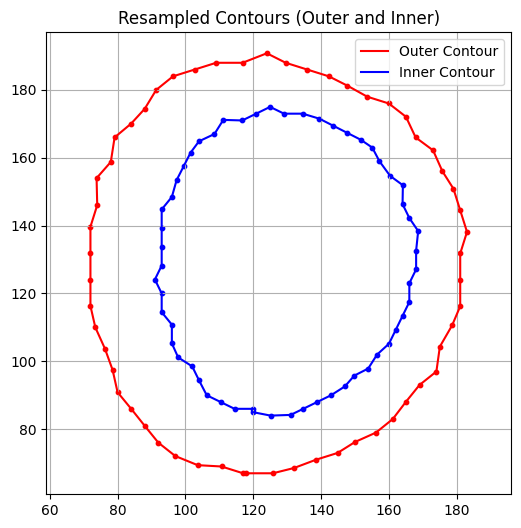

In [26]:
import matplotlib.pyplot as plt

# Plot the outer and inner contours
plt.figure(figsize=(6, 6))
plt.plot(resampled_outer[0], resampled_outer[1], 'r-', label='Outer Contour')
plt.plot(resampled_inner[0], resampled_inner[1], 'b-', label='Inner Contour')

# Optional: Add points to highlight samples
plt.scatter(resampled_outer[0], resampled_outer[1], color='red', s=10)
plt.scatter(resampled_inner[0], resampled_inner[1], color='blue', s=10)

plt.axis('equal')
plt.title('Resampled Contours (Outer and Inner)')
plt.legend()
plt.grid(True)
plt.show()
